<a href="https://colab.research.google.com/github/ricardoruedas/ML/blob/main/%5B04%5D%20-%20Modelos%20No%20Supervisados/No_supervisados_Ejercicio_1__pca_mall_customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# No supervisados - Ejercicio 1: pca_mall_customers.ipynb

Este notebook es **I do**. Está resuelto: ejecuta las celdas para ver paso a paso cómo aplicar PCA sobre el dataset *Mall Customers*, cómo elegir el número de componentes, cómo medir la pérdida por reconstrucción y cómo usar PCA como preprocesado antes de clustering. Lee las explicaciones en cada celda y observa los resultados.

## Objetivos

- Cargar el dataset *Mall Customers* (con fallback sintético si no está disponible).
- Estandarizar las variables y calcular PCA completo.
- Analizar varianza explicada y seleccionar componentes que retengan el 90% de la varianza.
- Medir el error de reconstrucción (MSE) para distintos números de componentes.
- Comparar el efecto de aplicar PCA antes de KMeans (inertia) y visualizar en 2D.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

np.random.seed(42)


### 1) Carga de datos

Intento cargar desde un par de URLs públicas. Si no se puede, genero un dataset sintético con la misma estructura para que puedas ejecutar el notebook sin dependencias de red.

In [10]:
url = 'https://raw.githubusercontent.com/dtoralg/INESDI_Data-Science_ML_IA/refs/heads/main/%5B04%5D%20-%20Modelos%20No%20Supervisados/Mall_Customers.csv'

df = pd.read_csv(url)
print('Cargado desde', url)


Cargado desde https://raw.githubusercontent.com/dtoralg/INESDI_Data-Science_ML_IA/refs/heads/main/%5B04%5D%20-%20Modelos%20No%20Supervisados/Mall_Customers.csv


### 2) Exploración rápida

Comprueba nulos, tipos y estadísticas resumidas; esto te ayudará a decidir qué columnas usar para PCA.

In [11]:
print('Porcentaje de nulos por columna:')
print((df.isnull().mean()*100).round(2))
print('\nTipos de columnas:')
print(df.dtypes)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('\nColumnas numéricas detectadas:', num_cols)

display(df[num_cols].describe().T)

Porcentaje de nulos por columna:
CustomerID                0.0
Genre                     0.0
Age                       0.0
Annual Income (k$)        0.0
Spending Score (1-100)    0.0
dtype: float64

Tipos de columnas:
CustomerID                 int64
Genre                     object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

Columnas numéricas detectadas: ['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


### 3) Preparación: encoding y selección de features

Codifico `Gender` y selecciono las variables numéricas relevantes para PCA: `Age`, `Annual Income (k$)` y `Spending Score (1-100)`. Puedes añadir más columnas si lo deseas, pero al menos estas tres son representativas para segmentación.

In [12]:
df_proc = df.copy()
if 'Genre' in df_proc.columns:
    le = LabelEncoder()
    df_proc['Gender'] = le.fit_transform(df_proc['Genre'].astype(str))
    df_proc = df_proc.drop('Genre', axis = 1)

features = df_proc.columns
X = df_proc.copy()
display(X.head())

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender
0,1,19,15,39,1
1,2,21,15,81,1
2,3,20,16,6,0
3,4,23,16,77,0
4,5,31,17,40,0


### 4) Escalado

Estandariza las features para que cada variable contribuya por igual a las componentes principales.

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
display(X_scaled_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,0.000000e+00,1.002509,-1.723412,-0.861706,0.000000,0.861706,1.723412
Age,200.0,-1.021405e-16,1.002509,-1.496335,-0.724844,-0.204535,0.728432,2.235532
Annual Income (k$),200.0,-2.131628e-16,1.002509,-1.738999,-0.727509,0.035879,0.665675,2.917671
Spending Score (1-100),200.0,-1.465494e-16,1.002509,-1.910021,-0.599793,-0.007764,0.885132,1.894492
Gender,200.0,3.108624e-17,1.002509,-0.886405,-0.886405,-0.886405,1.128152,1.128152


### 5) Cálculo de PCA y varianza explicada

Ajusto PCA completo (sin limitar el nº de componentes) y muestro la varianza explicada por cada componente y la acumulada. Esto te permite decidir cuántas componentes retener.

,explained_variance,cumulative
pc,,
1,0.397019,0.397019
2,0.269488,0.666507
3,0.194475,0.860981
4,0.134550,0.995531
5,0.004469,1.000000


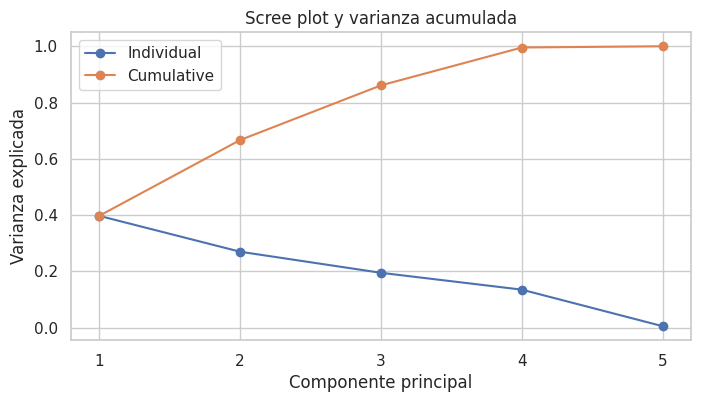

In [14]:
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)
explained = pca_full.explained_variance_ratio_
cumulative = np.cumsum(explained)

explained_df = pd.DataFrame({'pc': np.arange(1, len(explained)+1), 'explained_variance': explained, 'cumulative': cumulative})
explained_df.index = explained_df['pc']
display(explained_df[['explained_variance','cumulative']])

plt.figure(figsize=(8,4))
plt.plot(explained_df['pc'], explained_df['explained_variance'], marker='o', label='Individual')
plt.plot(explained_df['pc'], explained_df['cumulative'], marker='o', label='Cumulative')
plt.xlabel('Componente principal')
plt.ylabel('Varianza explicada')
plt.xticks(explained_df['pc'])
plt.legend()
plt.title('Scree plot y varianza acumulada')
plt.grid(True)
plt.show()

### 6) Elegir número de componentes para retener el 90% de la varianza

Calculo cuántas componentes necesito para retener el 90% de la varianza y creo la transformación correspondiente.

In [15]:
target_var = 0.90
n_components_90 = int(np.argmax(cumulative >= target_var) + 1)
print(f'Componentes necesarios para retener {int(target_var*100)}% de varianza: {n_components_90}')

pca90 = PCA(n_components=n_components_90)
X_pca_90 = pca90.fit_transform(X_scaled)
print('Shape after PCA (90%):', X_pca_90.shape)

Componentes necesarios para retener 90% de varianza: 4
Shape after PCA (90%): (200, 4)


In [16]:
df_pca = pd.DataFrame(X_pca_90)

In [ ]:
df_pca

,0,1,2,3
0,-2.316965,-0.454190,1.454230,-1.340150
1,-2.272391,-1.474104,1.712878,-0.087105
2,-2.454223,-0.006922,-0.733628,-2.177936
3,-2.386461,-1.749935,-0.291280,-0.079034
4,-2.397377,-0.369341,-0.636564,-0.686614
...,...,...,...,...
195,2.727733,-1.116329,-0.855862,0.622230
196,2.834568,0.739030,-1.330457,-0.265611
197,3.073113,-0.644900,1.078687,0.319267
198,3.331988,0.854022,0.674507,-1.211734


### 7) Reconstrucción y error de reconstrucción

Reconstruyo los datos desde diferentes números de componentes y mido el MSE para entender la pérdida de información que introduce la reducción dimensional.

,mse
k,
1,6.029811e-01
2,3.334934e-01
3,1.390188e-01
4,4.468746e-03
5,2.759463e-31


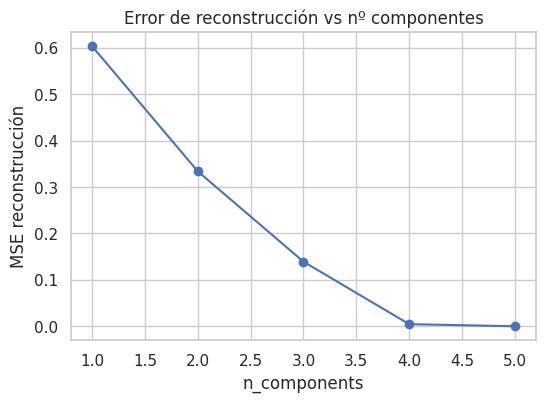

In [17]:
mse_records = []
for k in range(1, X_scaled.shape[1]+1):
    pca_k = PCA(n_components=k)
    Xk = pca_k.fit_transform(X_scaled)
    Xk_rec = pca_k.inverse_transform(Xk)
    mse = mean_squared_error(X_scaled, Xk_rec)
    mse_records.append({'k': k, 'mse': mse})

mse_df = pd.DataFrame(mse_records).set_index('k')
display(mse_df)

plt.figure(figsize=(6,4))
plt.plot(mse_df.index, mse_df['mse'], marker='o')
plt.xlabel('n_components')
plt.ylabel('MSE reconstrucción')
plt.title('Error de reconstrucción vs nº componentes')
plt.grid(True)
plt.show()

### 8) Visualización en 2D (PCA) y observaciones

Proyecto los datos en las dos primeras componentes principales y uso un gradiente con `Spending Score` para detectar patrones. Además muestro cómo se verían centroides de un KMeans de ejemplo en este espacio para ayudarte a interpretar los clusters.

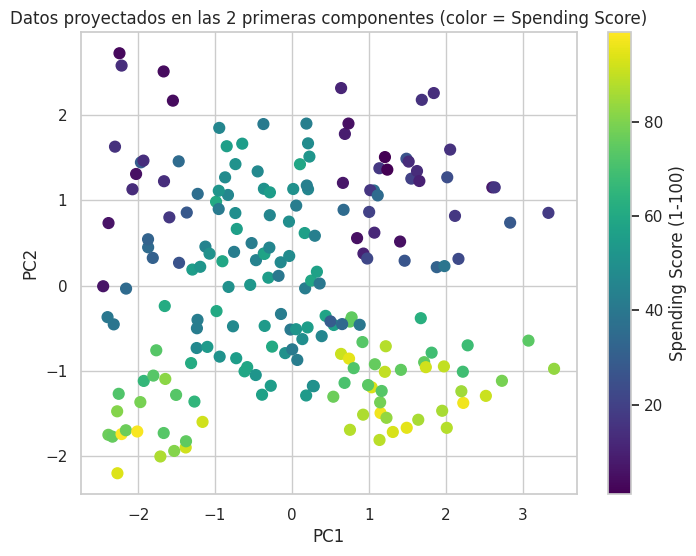

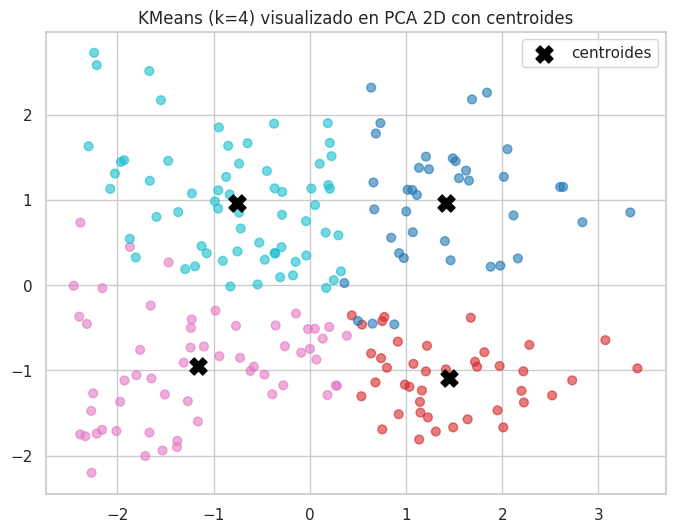

In [18]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=df_proc['Spending Score (1-100)'] if 'Spending Score (1-100)' in df_proc.columns else X_scaled[:, -1], cmap='viridis', s=60)
plt.colorbar(label='Spending Score (1-100)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Datos proyectados en las 2 primeras componentes (color = Spending Score)')
plt.show()

# Centroides de ejemplo
km_example = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_km_ex = km_example.fit_predict(X_scaled)
centroids = km_example.cluster_centers_
centroids_pca = pca2.transform(centroids)

plt.figure(figsize=(8,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_km_ex, cmap='tab10', s=40, alpha=0.6)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='black', s=150, marker='X', label='centroides')
plt.title('KMeans (k=4) visualizado en PCA 2D con centroides')
plt.legend()
plt.show()

### 9) PCA como preprocesado antes de clustering

Comparo la inercia de KMeans ejecutado sobre los datos escalados frente a la representación reducida por PCA (2 componentes y n_components_90). Esto te da una idea de cómo afecta PCA a la estructura de clusters.

In [19]:
km_orig = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X_scaled)
km_pca2 = KMeans(n_clusters=4, random_state=42, n_init=10).fit(pca2.transform(X_scaled))
km_pca90 = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X_pca_90)

print('Inertia original (scaled):', km_orig.inertia_)
print('Inertia PCA 2D:', km_pca2.inertia_)
print('Inertia PCA 90%:', km_pca90.inertia_)

Inertia original (scaled): 458.18341928674
Inertia PCA 2D: 175.93286483235184
Inertia PCA 90%: 453.9940328970365


### 10) Conclusión

Has calculado PCA, medido varianza explicada y evaluado la pérdida de información por reconstrucción. Para visualización se usan 2 componentes; para preprocesado antes de clustering usé las componentes necesarias para retener el 90% de varianza. PCA reduce dimensionalidad y ruido y acelera el clustering, aunque introduce una pérdida medida por el MSE de reconstrucción.